# Homework 7 - Part B

*Note that there are two different notebooks for HW assignment 7. This is part A. There will be two different assignments in gradescope for each part. The deadlines are the same for both parts.*

## References

+ Lectures 27-28 (inclusive).


## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

In [161]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

In [162]:
# Run this on Google colab
#!pip install pyro-ppl

In [163]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import torch

## Problem 1  - Bayesian Linear regression on steroids 

The purpose of this problem is to demonstrate that we have learned enough to do very complicated things.
In the first part, we will do Bayesian linear regression with radial basis functions (RBFs) in which we characterize the posterior of all parameters, including the length-scales of the RBFs.
In the second part, we are going to build a model that has an input-varying noise. Such models are called heteroscedastic models. 

We need to write some `pytorch` code to compute the design matrix. This is absolutely necessary so that `pyro` can differentiate through all expressions.

In [164]:
class RadialBasisFunctions(torch.nn.Module):
    """Radial basis functions basis.
    
    Arguments:
    X   -  The centers of the radial basis functions.
    ell -  The assumed length scale.
    """
    def __init__(self, X, ell):
        super().__init__()
        self.X = X
        self.ell = ell
        self.num_basis = X.shape[0]
    def forward(self, x):
        distances = torch.cdist(x, self.X)
        return torch.exp(-.5 * distances ** 2 / self.ell ** 2)

Here is how you can use them:

In [165]:
# Make the basis
x_centers = torch.linspace(-1, 1, 10).unsqueeze(-1)
ell = 0.2
basis = RadialBasisFunctions(x_centers, ell)

# Some points (need to be N x 1)
x = torch.linspace(-1, 1, 100).unsqueeze(-1)

# Evaluate the basis
Phi = basis(x)

# Here is the shape of Phi
print(Phi.shape)

torch.Size([100, 10])


Here is how they look like:

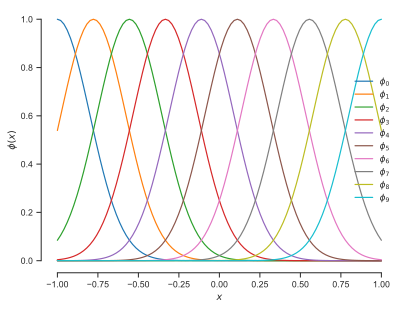

In [166]:
fig, ax = plt.subplots()
for i in range(Phi.shape[1]):
    ax.plot(x, Phi[:, i], label=f"$\phi_{i}$")
ax.set(xlabel="$x$", ylabel="$\phi(x)$")
ax.legend(loc="best", frameon=False)
sns.despine(trim=True);

### Part A - Hierarchical Bayesian linear regression with input-independent noise

We will analyze the motorcycle dataset. The data is loaded below.

In [167]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/motor.dat"
download(url)

We will work with the scaled data:

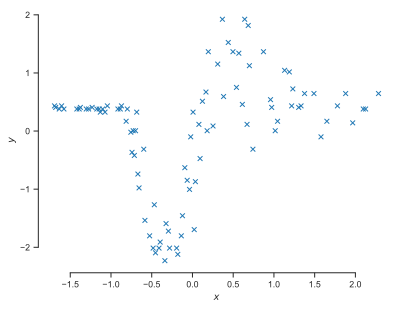

In [168]:
from sklearn.preprocessing import StandardScaler

data = np.loadtxt('motor.dat')
scaler = StandardScaler()
data = scaler.fit_transform(data)
X = torch.tensor(data[:, 0], dtype=torch.float32).unsqueeze(-1)
Y = torch.tensor(data[:, 1], dtype=torch.float32)

fig, ax = plt.subplots()
ax.plot(X, Y, 'x')
ax.set(xlabel="$x$", ylabel="$y$")
sns.despine(trim=True);

### Part A.I

Your goal is to implement the model described below.
We use the radial basis functions (`RadialBasisFunction`) with centers, $x_i$ at $m=50$ equidistant points between the minimum and maximum of the observed inputs:

$$
\phi_i(x;\ell) = \exp \left( - \frac{(x - x_i)^2}{2 \ell^2} \right),
$$

for $i=1,\dots,m$.
We denote the vector of RBFs evaluated at $x$ as $\boldsymbol{\phi}(x;\ell)$.

We are not going to pick the length-scales $\ell$ by hand. Instead, we will put a prior on it:

$$
\ell \sim \text{Exponential}(1).
$$

The corresponding weights have priors:

$$
w_j | \alpha_i \sim N(0, \alpha_j^2),
$$

and its $\alpha_j$ has a prior:

$$
\alpha_j \sim \text{Exponential}(1),
$$

for $j=1,\dots,m$.

Denote our data as:

$$
x_{1:n} = (x_1, \dots, x_n)^T,\;\text{(inputs)},
$$

and

$$
y_{1:n} = (y_1, \dots, y_n)^T,\;\text{(outputs)}.
$$

The likelihood of the data is:

$$
y_i | \mathbf{w}, \sigma \sim N(\mathbf{w}^T \boldsymbol{\phi}(x_i;\ell), \sigma^2),
$$

for $i=1,\dots,n$.

$$
y_n | \ell, \mathbf{w}, \sigma \sim N(\mathbf{w}^T \boldsymbol{\phi}(x_n;\ell), \sigma^2).
$$

Complete the `pyro` implementation of that model:

**Answer:**

In [169]:
def model(X, y, num_centers=50):
    with pyro.plate("centers", num_centers):
        alpha = pyro.sample("alpha", dist.Exponential(1.0))
        # Notice below that dist.Normal needs the standard deviation - not the variance
        # We follow a different convention in the lecture notes
        w = pyro.sample("w", dist.Normal(0.0, alpha))
    # Complete the code assign to ell the correct prior distribution (an Exponential(1))
    ell = pyro.sample("ell", dist.Exponential(1.0))
    # Hint: Look at alpha.
    # Complete the code assign to sigma the correct prior distribution (an Exponential(1))
    sigma = pyro.sample("sigma", dist.Exponential(1.0))
    x_centers = torch.linspace(X.min(), X.max(), num_centers).unsqueeze(-1)
    Phi = RadialBasisFunctions(x_centers, ell)(X)
    with pyro.plate("data", X.shape[0]):
        pyro.sample("y", dist.Normal(Phi @ w, sigma), obs=y)
    # Notice that I'm making the model return all the variables that I have made.
    # This is not essential for characterizing the posterior, but it does reduce redundant code
    # when we are trying to get the posterior predictive.
    return locals()

The graph will help to understand the model:

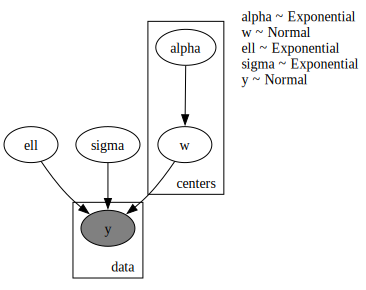

In [170]:
pyro.render_model(model, (X, Y), render_distributions=True)

Use `pyro.infer.autoguide.AutoDiagonalNormal` to make the guide:

In [171]:
guide = pyro.infer.autoguide.AutoDiagonalNormal(model)

We will use variational inference. Here is the training code from the hans-on activity:

In [172]:
def train(model, guide, data, num_iter=5_000):
    """Train a model with a guide.

    Arguments
    ---------
    model    -- The model to train.
    guide    -- The guide to train.
    data     -- The data to train the model with.
    num_iter -- The number of iterations to train.
    
    Returns
    -------
    elbos -- The ELBOs for each iteration.
    param_store -- The parameters of the model.
    """

    pyro.clear_param_store()

    optimizer = pyro.optim.Adam({"lr": 0.001})

    svi = pyro.infer.SVI(
        model,
        guide,
        optimizer,
        loss=pyro.infer.JitTrace_ELBO()
    )

    elbos = []
    for i in range(num_iter):
        loss = svi.step(*data)
        elbos.append(-loss)
        if i % 1_000 == 0:
            print(f"Iteration: {i} Loss: {loss}")

    return elbos, pyro.get_param_store()

### Part A.II

Train the model for 20,000 iterations. Call the `train()` function we defined above to do it.
Make sure you store the returned elbo values because you will need them later.

**Answer:**

In [173]:
# Your code here
num_iter = 20_000
data = (X, Y)

elbos, param_store = train(model, guide, data, num_iter)

Iteration: 0 Loss: 293.7839050292969
Iteration: 1000 Loss: 203.90066528320312
Iteration: 2000 Loss: 155.63087463378906
Iteration: 3000 Loss: 133.1307373046875
Iteration: 4000 Loss: 146.24481201171875
Iteration: 5000 Loss: 152.30543518066406
Iteration: 6000 Loss: 135.88711547851562
Iteration: 7000 Loss: 131.27069091796875
Iteration: 8000 Loss: 128.0336151123047
Iteration: 9000 Loss: 124.18950653076172
Iteration: 10000 Loss: 123.76417541503906
Iteration: 11000 Loss: 126.7149429321289
Iteration: 12000 Loss: 118.48756408691406
Iteration: 13000 Loss: 136.76763916015625
Iteration: 14000 Loss: 126.47525024414062
Iteration: 15000 Loss: 141.35157775878906
Iteration: 16000 Loss: 127.17459869384766
Iteration: 17000 Loss: 132.1529541015625
Iteration: 18000 Loss: 125.85560607910156
Iteration: 19000 Loss: 131.2788848876953


### Part A.III

Plot the evolution of the ELBO.

**Answer:**

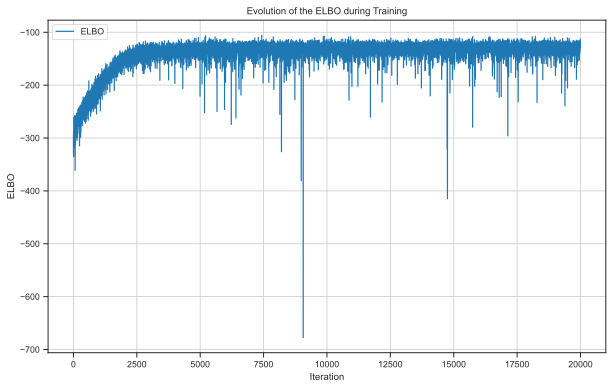

In [174]:
# Your code here
plt.figure(figsize=(10, 6))
plt.plot(elbos, label="ELBO")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.title("Evolution of the ELBO during Training")
plt.legend()
plt.grid(True)
plt.show()

### Part A.IV

Take 1,000 posterior samples.

**Answer:**

I'm giving you this one because it is a bit tricky. You need to use the `pyro.infer.Predictive` class to do it. Here is how you can use it:

In [175]:
post_samples = pyro.infer.Predictive(model, guide=guide, num_samples=10)(X, Y)
# Just modify the call to get the right number of samples

### Part A.V

Plot the histograms of the posteriors of $\ell$, $\sigma$, $\alpha_{10}$ and $w_{10}$.

**Answer:**

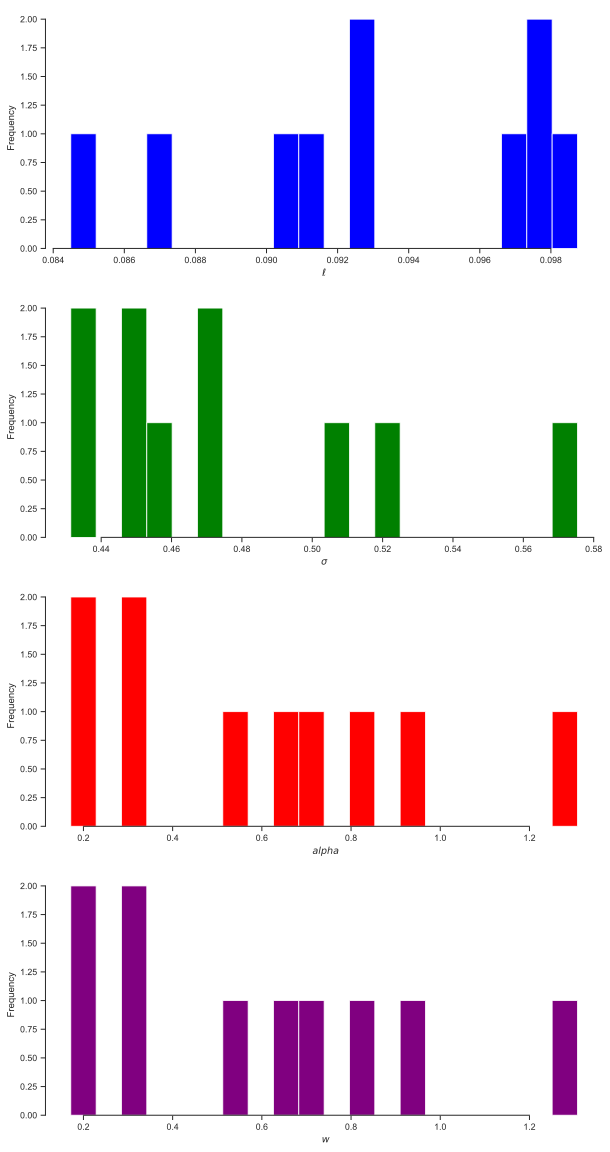

In [176]:
# First, here is how to extract the samples.
ell = post_samples["ell"]
# You can do `post_samples.keys()` to see all the keys.
# But they should correspond to the names of the latent variables in the model.
sigma = post_samples["sigma"]
alphas = post_samples["alpha"]
ws = post_samples["w"]
alpha_10 = alphas[:,10]
w_10 = alphas[:,10]

# Here is the code to make the histogram for the length scale.
fig, axs = plt.subplots(4,1,figsize=(10, 20))
# **VERY IMPORTANT** - You need to detach the tensor from the computational graph.
# Otherwise, you will get very very strange behavior.
axs[0].hist(ell.detach().numpy(), bins=20, color='blue')
axs[0].set(xlabel="$\ell$", ylabel="Frequency")


# Your code for the other histograms here
# Here is the code to make the histogram for the length scale.

# **VERY IMPORTANT** - You need to detach the tensor from the computational graph.
# Otherwise, you will get very very strange behavior.
axs[1].hist(sigma.detach().numpy(), bins=20, color='green')
axs[1].set(xlabel="$\sigma$", ylabel="Frequency")



# **VERY IMPORTANT** - You need to detach the tensor from the computational graph.
# Otherwise, you will get very very strange behavior.
axs[2].hist(alpha_10.detach().numpy(), bins=20, color='red')
axs[2].set(xlabel="$\ alpha$", ylabel="Frequency")



# **VERY IMPORTANT** - You need to detach the tensor from the computational graph.
# Otherwise, you will get very very strange behavior.
axs[3].hist(w_10.detach().numpy(), bins=20, color='purple')
axs[3].set(xlabel="$\ w$", ylabel="Frequency")
sns.despine(trim=True);


### Part A.VI

Let's extend them model to make predictions.

**Answer:**

In [177]:
# Again, I'm giving you most of the code here.

def predictive_model(X, y, num_centers=50):
    # First we run the original model get all the variables
    params = model(X, y, num_centers)
    # Here is how you can access the variables
    w = params["w"]
    ell = params["ell"]
    sigma = params["sigma"]
    x_centers = params["x_centers"]
    # Here are the points where we want to make predictions
    xs = torch.linspace(X.min(), X.max(), 100).unsqueeze(-1)
    # Evaluate the basis on the prediction points
    Phi = RadialBasisFunctions(x_centers, ell)(xs)
    # Make the predictions - we use a deterministic node here because we want to
    # save the results of the predictions.
    predictions = pyro.deterministic("predictions", Phi @ w)
    # Finally, we add the measurement noise
    predictions_with_noise = pyro.sample("predictions_with_noise", dist.Normal(predictions, sigma))
    return locals()

### Part A.VII

Extract the posterior predictive distribution using 10,000 samples. Separate aleatory and epistemic uncertainty.

**Answer:**

In [178]:
# Here is how to make the predictions. Just change the number of samples to the right number.
post_pred = pyro.infer.Predictive(predictive_model, guide=guide, num_samples=10)(X, Y)
# We will predict here:
xs = torch.linspace(X.min(), X.max(), 100).unsqueeze(-1)
# You can extract the predictions from post_pred like this:
predictions = post_pred["predictions"]
# Note that we extracted the deterministic node called "predictions" from the model.
# Get the epistemic uncertainty in the usual way:
p_500, p_025, p_975 = np.percentile(predictions, [50, 2.5, 97.5], axis=0)
# Extract predictions with noise
predictions_with_noise = post_pred["predictions_with_noise"]
# Get the aleatory uncertainty
ap_025, ap_975 = np.percentile(predictions_with_noise, [2.5, 97.5], axis=0)

### Part A.VIII

Plot the data, the median, the 95% credible interval of epistemic uncertainty and the 95% credible interval of aleatory uncertainty, along with five samples from the posterior.

**Answer:**

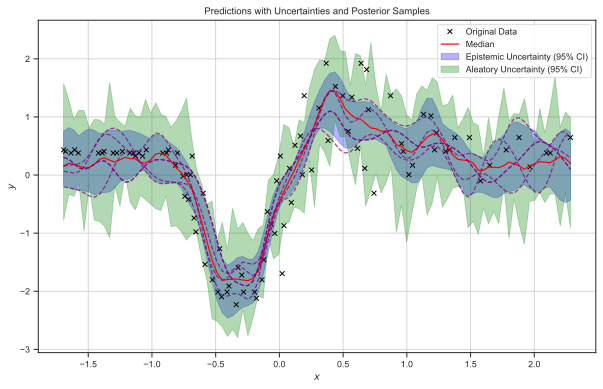

In [179]:
# Your code here. You have everything you need to make the plot.

#Ensure xs is the same shape as p_500 for plotting
xs = xs.squeeze().numpy()

# Reshape p_500, p_025, and p_975 for plotting
p_500 = p_500.squeeze()
p_025 = p_025.squeeze()
p_975 = p_975.squeeze()

# Reshape ap_025 and ap_975 for plotting
ap_025 = ap_025.squeeze()
ap_975 = ap_975.squeeze()

# Plot the original data, predictions, and uncertainties
plt.figure(figsize=(10, 6))
plt.plot(X.numpy(), Y.numpy(), 'x', label='Original Data', color='black')
plt.plot(xs, p_500, label='Median', color='red')

# Plot epistemic uncertainty
plt.fill_between(xs, p_025, p_975, color='blue', alpha=0.3, label='Epistemic Uncertainty (95% CI)')

# Plot aleatory uncertainty
plt.fill_between(xs, ap_025, ap_975, color='green', alpha=0.3, label='Aleatory Uncertainty (95% CI)')

# Plot five samples from the posterior
for i in range(5):
    sample_idx = np.random.choice(predictions.shape[0])
    plt.plot(xs, predictions[sample_idx].squeeze(), color='purple', alpha=0.75, linestyle='--')

plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Predictions with Uncertainties and Posterior Samples")
plt.legend()
plt.grid(True)
plt.show()

### Part B - Heteroscedastic regression

We are going to build a model that has an input-varying noise. Such models are called heteroscedastic models.
Here I will let you do more of the work.

Everything is as before for $\ell$, the $\alpha_j$'s, and the $w_j$'s.
We now introduce a model for the noise that is input dependent.
It will use the same RBFs as the mean function.
But let's use a different length-scale, $\ell_\sigma$.
So, we add:

$$
\ell_\sigma \sim \text{Exponential}(1),
$$

$$
\alpha_{\sigma,j} \sim \text{Exponential}(1),
$$

and

$$
w_{\sigma,j} | \alpha_{\sigma,j} \sim N(0, \alpha_{\sigma,j}^2),
$$

for $j=1,\dots,m$.

Our model for the input-dependent noise variance is:

$$
\sigma(x;\mathbf{w}_\sigma,\ell) = \exp\left(\mathbf{w}_\sigma^T \boldsymbol{\phi}(x;\ell_\sigma)\right).
$$

So, the likelihood of the data is:

$$
y_i | \mathbf{w}, \mathbf{w}_\sigma \sim N\left(\mathbf{w}^T \boldsymbol{\phi}(x_i;\ell), \sigma^2(x_i;\mathbf{w}_\sigma,\ell)\right),
$$

You will implement this model.

### Part B.I

Complete the code below:

In [180]:
def model1(X, y, num_centers=50):
    with pyro.plate("centers", num_centers):
        alpha = pyro.sample("alpha", dist.Exponential(1.0))
        w = pyro.sample("w", dist.Normal(0.0, alpha))
        # Let's add the generalized linear model for the log noise.
        alpha_noise = pyro.sample("alpha_noise", dist.Exponential(1.0))
        w_noise = pyro.sample("w_noise", dist.Normal(0.0, alpha_noise))
    ell = pyro.sample("ell", dist.Exponential(1.))
    ell_noise = pyro.sample("ell_noise", dist.Exponential(1.))
    x_centers = torch.linspace(X.min(), X.max(), num_centers).unsqueeze(-1)
    Phi = RadialBasisFunctions(x_centers, ell)(X)
    Phi_noise = RadialBasisFunctions(x_centers, ell_noise)(X)
    # This is the new part 2/2
    model_mean = Phi @ w
    model_mean_noise = Phi_noise @ w_noise
    sigma = torch.exp(model_mean_noise)
    with pyro.plate("data", X.shape[0]):
        pyro.sample("y", dist.Normal(model_mean, sigma), obs=y)
    return locals()

Make a `pyro.infer.autoguide.AutoDiagonalNormal` guide:

In [181]:
# Your code here
from pyro.infer.autoguide import AutoDiagonalNormal

guide = AutoDiagonalNormal(model1)

Make the graph of the model using `pyro` functionality:

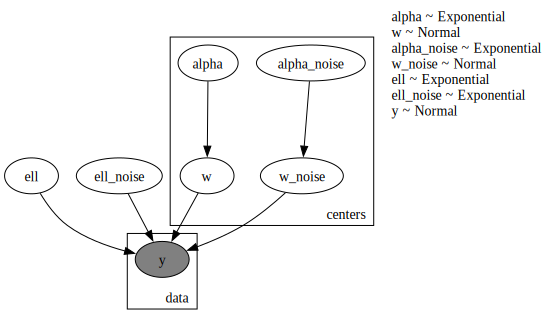

In [182]:
# Your code here
pyro.render_model(model1, (X, Y), render_distributions=True)

### Part B.II

Train the model using 20,000 iterations. Then plot the evolution of the ELBO.

**Answer:**

In [183]:
# Your code here
num_iter = 20_000
elbos, param_store = train(model1, guide, data, num_iter)

Iteration: 0 Loss: 532.7073364257812
Iteration: 1000 Loss: 317.6937255859375
Iteration: 2000 Loss: 265.41607666015625
Iteration: 3000 Loss: 186.05316162109375
Iteration: 4000 Loss: 215.87327575683594
Iteration: 5000 Loss: 178.5106658935547
Iteration: 6000 Loss: 180.7362060546875
Iteration: 7000 Loss: 185.17767333984375
Iteration: 8000 Loss: 192.96360778808594
Iteration: 9000 Loss: 164.2666778564453
Iteration: 10000 Loss: 163.99436950683594
Iteration: 11000 Loss: 181.34283447265625
Iteration: 12000 Loss: 162.32705688476562
Iteration: 13000 Loss: 174.7813720703125
Iteration: 14000 Loss: 158.75184631347656
Iteration: 15000 Loss: 188.15733337402344
Iteration: 16000 Loss: 207.44119262695312
Iteration: 17000 Loss: 170.92857360839844
Iteration: 18000 Loss: 176.744384765625
Iteration: 19000 Loss: 158.02159118652344


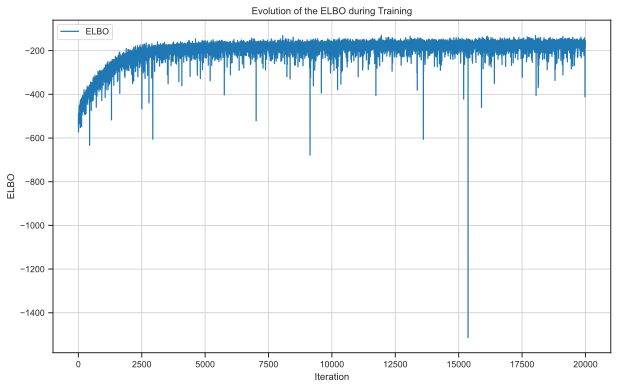

In [184]:
plt.figure(figsize=(10, 6))
plt.plot(elbos, label="ELBO")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.title("Evolution of the ELBO during Training")
plt.legend()
plt.grid(True)
plt.show()

### Part B.III

Extend the model to make predictions.

**Answer:**

In [185]:
def predictive_model(X, y, num_centers=50):
    params = model1(X, y, num_centers)
    w = params["w"]
    w_noise = params["w_noise"]
    ell = params["ell"]
    ell_noise = params["ell_noise"]
    sigma = params["sigma"]
    x_centers = params["x_centers"]
    xs = torch.linspace(X.min(), X.max(), 100).unsqueeze(-1)
    Phi = RadialBasisFunctions(x_centers, ell)(xs)
    Phi_noise = RadialBasisFunctions(x_centers, ell_noise)(xs)
    #Phi = params["Phi"]
    #Phi_noise = params["Phi_noise"]
    predictions = pyro.deterministic("predictions", Phi @ w)
    sigma = pyro.deterministic("sigma", torch.exp(Phi_noise @ w_noise))
    predictions_with_noise = pyro.sample("predictions_with_noise", dist.Normal(predictions, sigma))
    return locals()

### Part B.IV

Now, make predictions and calculate the epistemic and aleatory uncertainties as in part A.VII.

**Answer:**

In [186]:
# Your code here
# Here is how to make the predictions. Just change the number of samples to the right number.
post_pred = pyro.infer.Predictive(predictive_model, guide=guide, num_samples=10)(X, Y)
# We will predict here:
xs = torch.linspace(X.min(), X.max(), 100).unsqueeze(-1)
# You can extract the predictions from post_pred like this:
predictions = post_pred["predictions"]
# Note that we extracted the deterministic node called "predictions" from the model.
# Get the epistemic uncertainty in the usual way:
p_500, p_025, p_975 = np.percentile(predictions, [50, 2.5, 97.5], axis=0)
# Extract predictions with noise
predictions_with_noise = post_pred["predictions_with_noise"]
# Get the aleatory uncertainty
ap_025, ap_975 = np.percentile(predictions_with_noise, [2.5, 97.5], axis=0)

### Part B.V

Make the same plot as in part A.VIII.

**Answer:**

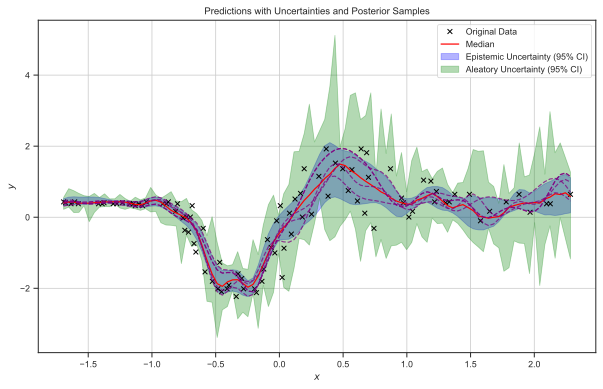

In [187]:
# Your code here

#Ensure xs is the same shape as p_500 for plotting
xs = xs.squeeze().numpy()

# Reshape p_500, p_025, and p_975 for plotting
p_500 = p_500.squeeze()
p_025 = p_025.squeeze()
p_975 = p_975.squeeze()

# Reshape ap_025 and ap_975 for plotting
ap_025 = ap_025.squeeze()
ap_975 = ap_975.squeeze()

# Plot the original data, predictions, and uncertainties
plt.figure(figsize=(10, 6))
plt.plot(X.numpy(), Y.numpy(), 'x', label='Original Data', color='black')
plt.plot(xs, p_500, label='Median', color='red') #TODO: somehow p_500 has only 94 points........

# Plot epistemic uncertainty
plt.fill_between(xs, p_025, p_975, color='blue', alpha=0.3, label='Epistemic Uncertainty (95% CI)')

# Plot aleatory uncertainty
plt.fill_between(xs, ap_025, ap_975, color='green', alpha=0.3, label='Aleatory Uncertainty (95% CI)')


# Plot five samples from the posterior
for i in range(5):
    sample_idx = np.random.choice(predictions.shape[0])
    plt.plot(xs, predictions[sample_idx].squeeze(), color='purple', alpha=0.75, linestyle='--')

plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Predictions with Uncertainties and Posterior Samples")
plt.legend()
plt.grid(True)
plt.show()

### Part B.VI

Plot the estimated noise standard deviation as a function of of the input along with a 95% credible interval.

**Answer:**

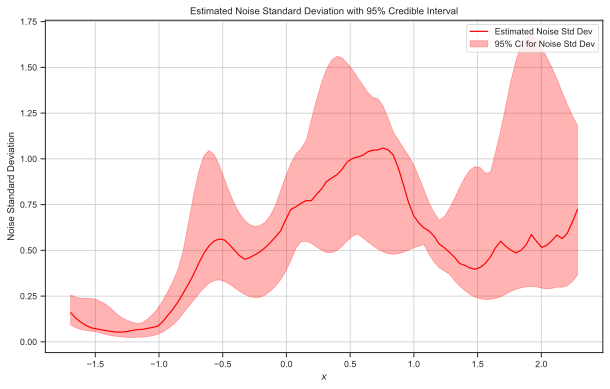

In [188]:
# Your code here



# Extract the noise standard deviation
sigma = post_pred["sigma"]

# Calculate the 95% credible interval for the noise standard deviation
sigma_500, sigma_025, sigma_975 = np.percentile(sigma, [50, 2.5, 97.5], axis=0)

# Reshape p_500, p_025, and p_975 for plotting
sigma_500 = sigma_500.squeeze()
sigma_025 = sigma_025.squeeze()
sigma_975 = sigma_975.squeeze()

# Plot the estimated noise standard deviation
plt.figure(figsize=(10, 6))
plt.plot(xs, sigma_500, label='Estimated Noise Std Dev', color='red')

# Plot the 95% credible interval for the noise standard deviation
plt.fill_between(xs, sigma_025, sigma_975, color='red', alpha=0.3, label='95% CI for Noise Std Dev')

plt.xlabel("$x$")
plt.ylabel("Noise Standard Deviation")
plt.title("Estimated Noise Standard Deviation with 95% Credible Interval")
plt.legend()
plt.grid(True)
plt.show()

### Part B.VII

Which model do you prefer? Why?

**Answer:**
<br><br><br><br><br><br><br><br><br><br><br><br><br><br>

### Part B.IX

Can you think of any way to improve the model?
Go crazy! This is the last homework assignment!
There is no right or wrong answer here.
But if you have a good idea, we will give you extra credit.

In [189]:
## Your code and answers here